In [7]:
# create code here
from simu import simu_RRR
from fitting import *
import numpy as np

### Regularization

In [4]:
n_sim = 50
nx = 50
ny = 50
NSamples = np.round(50 * 2 ** np.arange(1, 4.5, 0.5)).astype(int)
Lambdas = np.array(list(range(11)) + [20, 100, 1000])

def err_fun(A, B):
    return np.mean((A - B) ** 2) / np.mean(B ** 2)

U = []
V = []
err = np.full((n_sim, len(Lambdas), len(NSamples)), np.nan)

# generate simulated data
for isim in range(n_sim):
    X, Y, U, V, ops = simu_RRR({
        'rnk': 2,
        'nx': nx,
        'ny': ny,
        'signse': 50,
        'T': max(NSamples),
        'U': U,
        'V': V
    })
    w_true = U @ V.T
    for jj, lam in enumerate(Lambdas):
        w_hat_list = [
            svd_RRR(X[:n_sample, :], Y[:n_sample, :], ops['rnk'], lam)[0]
            for n_sample in NSamples
        ]
        err[isim, jj, :] = [err_fun(w_hat, w_true) for w_hat in w_hat_list]

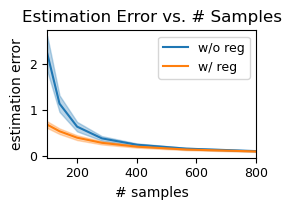

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Identify best lambda
tmp = np.mean(err, axis=0)  # shape: (len(Lambdas), len(NSamples))
I = np.argmin(tmp, axis=0)  # best lambda for each sample count

# Plotting
plt.close('all')
fig, ax = plt.subplots(figsize=(3, 2.2))  # size in inches
ax.set_title('Estimation Error vs. # Samples')

# Prepare data: err shape is (n_sim, len(Lambdas), len(NSamples))
# Select lambda index 0 (no regularization) and I[-1] (best at max sample)
selected_idxs = [0, I[-1]]
err_to_plot = err[:, selected_idxs, :]  # shape: (n_sim, 2, len(NSamples))
err_to_plot = np.transpose(err_to_plot, (0, 2, 1))  # shape: (n_sim, len(NSamples), 2)

# Plot mean ± std
labels = ['w/o reg', 'w/ reg']
colors = ['tab:blue', 'tab:orange']
for i in range(2):
    mean_err = np.mean(err_to_plot[:, :, i], axis=0)
    std_err = np.std(err_to_plot[:, :, i], axis=0)
    ax.plot(NSamples, mean_err, label=labels[i], color=colors[i])
    ax.fill_between(NSamples, mean_err - std_err, mean_err + std_err, color=colors[i], alpha=0.3)

# Labels and legend
ax.set_xlabel('# samples')
ax.set_ylabel('estimation error')
ax.legend(fontsize=9)
ax.set_xlim(min(NSamples), max(NSamples))
ax.tick_params(labelsize=9)

# Save figure
plt.tight_layout()
plt.savefig('fig2a.png', dpi=300)
plt.show()


### Non-isotropic noise

In [4]:
# simulation parameters
n_sim = 100
nx = 50
ny = 50
Lambdas = np.array(list(range(11)) + [20, 100, 1000])
M_sigma = np.linspace(1,500,6) # maximum variance of neurons

def err_fun(A, B):
    return np.mean((A - B) ** 2) / np.mean(B ** 2)


err = np.full((n_sim, len(M_sigma), 2), np.nan)

In [5]:
# generate simulated data
for ii in range(len(M_sigma)):
    
    # generate groudn truth covariance
    # Sigma = np.diag(np.logspace(0, np.log10(M_sigma[ii]), ny)) # variance on a log scale
    # Sigma = np.diag(np.linspace(1, M_sigma[ii], ny)) # variance on a linear scale
    Sigma = np.diag(np.concatenate([np.ones(ny - 1), [M_sigma[ii]]])) # variance all ones except the last
    
    for isim in range(n_sim):
        X, Y, U, V, ops = simu_RRR({
            'rnk': 2,
            'nx': nx,
            'ny': ny,
            'signse': 50,
            'T': 100,
            'Sigma':Sigma})
        w_true = U @ V.T
        
        w_hat_list = [svd_RRR(X,Y,ops['rnk'])[0], 
                      svd_RRR_noniso(X,Y,ops['rnk'],Sigma)[0]]
        err[isim, ii, :] = [err_fun(w_hat, w_true) for w_hat in w_hat_list]

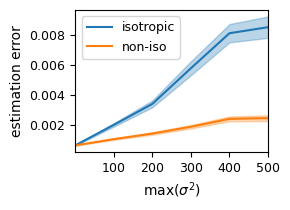

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Example structure
# err.shape == (n_sim, len(M_sigma), 2)
# M_sigma = [10, 100, 1000]  # or any list of values

plt.close('all')
fig, ax = plt.subplots(figsize=(3, 2.2))  # inches, as in MATLAB [3 2.2]*72 dpi

colors = plt.get_cmap('tab10').colors  # similar to MATLAB 'lines' colormap

labels = ['isotropic', 'non-iso']

for ii in range(2):
    mean_err = np.mean(err[:, :, ii], axis=0)
    std_err = np.std(err[:, :, ii], axis=0) / np.sqrt(err.shape[0])
    ax.plot(M_sigma, mean_err, label=labels[ii], color=colors[ii])
    ax.fill_between(M_sigma, mean_err - std_err, mean_err + std_err, color=colors[ii], alpha=0.3)

# Axis labels
ax.set_xlabel(r'max($\sigma^2$)', fontsize=10)
ax.set_ylabel('estimation error', fontsize=10)

# Legend
ax.legend(fontsize=9)

# Axes formatting
ax.set_xlim(min(M_sigma), max(M_sigma))
ax.tick_params(labelsize=9)

# Layout and save
plt.tight_layout()
plt.savefig('fig2b.png', dpi=300)
plt.show()
